<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Findings" data-toc-modified-id="Findings-1">Findings</a></span></li><li><span><a href="#Retrieve-&amp;-clean-geo-data" data-toc-modified-id="Retrieve-&amp;-clean-geo-data-2">Retrieve &amp; clean geo data</a></span><ul class="toc-item"><li><span><a href="#Scrape-into-dataframe" data-toc-modified-id="Scrape-into-dataframe-2.1">Scrape into dataframe</a></span></li><li><span><a href="#Remove-null-boroughs" data-toc-modified-id="Remove-null-boroughs-2.2">Remove null <code>borough</code>s</a></span></li><li><span><a href="#Replace-null-neighborhoods-with-borough" data-toc-modified-id="Replace-null-neighborhoods-with-borough-2.3">Replace null <code>neighborhood</code>s with <code>borough</code></a></span></li><li><span><a href="#Combine-neighborhoods-by-postcode" data-toc-modified-id="Combine-neighborhoods-by-postcode-2.4">Combine <code>neighborhood</code>s by <code>postcode</code></a></span></li><li><span><a href="#Get-geo-coordinates-of-each-postal-code" data-toc-modified-id="Get-geo-coordinates-of-each-postal-code-2.5">Get geo-coordinates of each postal code</a></span></li><li><span><a href="#Visualize-neighborhood-locations" data-toc-modified-id="Visualize-neighborhood-locations-2.6">Visualize neighborhood locations</a></span></li></ul></li><li><span><a href="#Retrieve-&amp;-clean-venue-data" data-toc-modified-id="Retrieve-&amp;-clean-venue-data-3">Retrieve &amp; clean venue data</a></span><ul class="toc-item"><li><span><a href="#Pull-venues-from-foursquare-API" data-toc-modified-id="Pull-venues-from-foursquare-API-3.1">Pull venues from foursquare API</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-4">EDA</a></span><ul class="toc-item"><li><span><a href="#Category-sparsity" data-toc-modified-id="Category-sparsity-4.1">Category sparsity</a></span></li></ul></li><li><span><a href="#Modeling-&amp;-evaluation" data-toc-modified-id="Modeling-&amp;-evaluation-5">Modeling &amp; evaluation</a></span><ul class="toc-item"><li><span><a href="#Category-grouping-at-level-2" data-toc-modified-id="Category-grouping-at-level-2-5.1">Category grouping at level 2</a></span><ul class="toc-item"><li><span><a href="#k-means" data-toc-modified-id="k-means-5.1.1">k-means</a></span></li><li><span><a href="#DBSCAN" data-toc-modified-id="DBSCAN-5.1.2">DBSCAN</a></span></li></ul></li><li><span><a href="#Category-grouping-at-level-3" data-toc-modified-id="Category-grouping-at-level-3-5.2">Category grouping at level 3</a></span><ul class="toc-item"><li><span><a href="#k-means" data-toc-modified-id="k-means-5.2.1">k-means</a></span></li><li><span><a href="#DBSCAN" data-toc-modified-id="DBSCAN-5.2.2">DBSCAN</a></span></li></ul></li><li><span><a href="#Category-grouping-at-level-1" data-toc-modified-id="Category-grouping-at-level-1-5.3">Category grouping at level 1</a></span><ul class="toc-item"><li><span><a href="#k-means" data-toc-modified-id="k-means-5.3.1">k-means</a></span></li><li><span><a href="#DBSCAN" data-toc-modified-id="DBSCAN-5.3.2">DBSCAN</a></span></li></ul></li><li><span><a href="#Without-category-grouping" data-toc-modified-id="Without-category-grouping-5.4">Without category grouping</a></span><ul class="toc-item"><li><span><a href="#k-means" data-toc-modified-id="k-means-5.4.1">k-means</a></span></li><li><span><a href="#DBSCAN" data-toc-modified-id="DBSCAN-5.4.2">DBSCAN</a></span></li></ul></li></ul></li></ul></div>

# Coursera Applied Data Science Capstone Project
**Week 3 - Segmenting and Clustering Neighborhoods in Toronto**

In [379]:
import pandas as pd
import numpy as np

import seaborn as sns

import folium
import requests
from tqdm.auto import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer

## Findings

Both $k$-means and DBSCAN clustering resulted in relatively poor silhouette scores at all category grouping levels. The DBSCAN algorithm found exclusively noise in approximately 80% of the grid searched parameter combinations. No score exceeded 0.20 (see table below).

| Silhouette Score | Level 1 | Level 2 | Level 3 | No Grouping |
|------------------|---------|---------|---------|-------------|
| **k-means**          | 0.192   | 0.178   | 0.160   | 0.153       |
| **DBSCAN**           | 0.182   | 0.140   | 0.142   | 0.142       |

>**_Our model does not yield cohesive, well-separated clusters._**

One possible explanation for the lack of good clustering is that our dataset, which focuses on the similarity of venues in a neighborhood, might benefit from including more distinguishing features of  neighborhoods. A next step might be to include data points such as the following to improve the strength of the clustering algorithm:
- availability of public transit
- rent prices
- resident demographics

----

## Retrieve & clean geo data

### Scrape into dataframe

In [2]:
data = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', 
                    na_values='Not assigned')
df = data[0].sort_values(by='Postcode')

In [3]:
df.columns = df.columns.str.lower()

In [4]:
df.shape

(287, 3)

In [5]:
df.head()

,postcode,borough,neighborhood
0,M1A,NaN,NaN
11,M1B,Scarborough,Malvern
10,M1B,Scarborough,Rouge
28,M1C,Scarborough,Port Union
27,M1C,Scarborough,Rouge Hill


### Remove null `borough`s

In [6]:
df = df[~df['borough'].isnull()]
df.head()

,postcode,borough,neighborhood
11,M1B,Scarborough,Malvern
10,M1B,Scarborough,Rouge
28,M1C,Scarborough,Port Union
27,M1C,Scarborough,Rouge Hill
26,M1C,Scarborough,Highland Creek


### Replace null `neighborhood`s with `borough`

In [7]:
df['neighborhood'].isnull().sum()

1

In [8]:
null_filter = df['neighborhood'].isnull()
df.loc[null_filter, 'neighborhood'] = df.loc[null_filter, 'borough']

In [9]:
df['neighborhood'].isnull().sum()

0

### Combine `neighborhood`s by `postcode`

Confirm `one:many` relationship between `borough:postcode`. This will allow us to groupby `postcode` alone.

In [10]:
df.groupby('postcode')['borough'].apply(lambda x: x.nunique() == 1).all()

# from https://stackoverflow.com/questions/
#            50643386/easy-way-to-see-if-two-columns-are-one-to-one-in-pandas

True

Roll up the neighborhoods and consolidate the dataframe

In [11]:
nhoods_by_postcode = df.groupby('postcode').apply(lambda x: ', '.join(
    [str(each) for each in np.repeat(x['neighborhood'].values.tolist(), 1)]))

# h/t https://stackoverflow.com/questions/
#           31243352/concatenate-row-values-for-the-same-index-in-pandas

In [12]:
df = df.groupby('postcode').agg('first')

In [13]:
df['neighborhood'] = nhoods_by_postcode
df.reset_index(inplace=True)
df.head()

,postcode,borough,neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Port Union, Rouge Hill, Highland Creek"
2,M1E,Scarborough,"West Hill, Morningside, Guildwood"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [14]:
df.shape

(103, 3)

### Get geo-coordinates of each postal code

I used the .csv file because of the unreliability of the `geocoder` package

In [15]:
df_ll = pd.read_csv('data/Geospatial_Coordinates.csv', 
                    names=['lat', 'long'],
                    skiprows=1)
df_ll.head()

,lat,long
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


In [16]:
df = df.join(df_ll, on='postcode')
df.head()

,postcode,borough,neighborhood,lat,long
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Port Union, Rouge Hill, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"West Hill, Morningside, Guildwood",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Visualize neighborhood locations

Since our goal is to find neighborhoods we might want to move to in Toronto proper, we'll limit analysis to those postcodes belonging to boroughs with "Toronto" in the name.

Get the central coordinates for Toronto proper

In [48]:
toronto = df.loc[df['borough'].str.lower().str.contains('toronto')]
toronto.shape

In [49]:
latitude, longitude = toronto.iloc[:, -2:].mean().ravel()

Set up borough/postal code labels for markers

In [51]:
labels = toronto.borough.str.cat(toronto.postcode, sep=' - ')
labels.head()

37       East Toronto - M4E
41       East Toronto - M4K
42       East Toronto - M4L
43       East Toronto - M4M
44    Central Toronto - M4N
Name: borough, dtype: object

In [65]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add Toronto center as a red circle mark
folium.CircleMarker(
    [latitude, longitude],
    radius=75,
    popup='Toronto',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.25,
    weight=0
    ).add_to(venues_map)


# add popular spots to the map as blue circle markers
for lat, long, label in zip(toronto.lat, toronto.long, labels):
    folium.CircleMarker(
        [lat, long],
        radius=3,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.4,
        weight=1
        ).add_to(venues_map)

# display map
venues_map

## Retrieve & clean venue data

### Pull venues from foursquare API

In [86]:
CLIENT_ID = 'VXYAGD1UCDJXEPUG3JUKI24MZMLYQUOPMYMEDB0MBXZQFMU3' # your Foursquare ID
CLIENT_SECRET = '1QR1DGV15DE0QEZM5VVYSDFQ1TZJMSP1G4TYVP2ITYYLMWMF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

def get_nearby_venues(nhood_names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for nhood_name, lat, lng in zip(nhood_names, latitudes, longitudes):
        print(nhood_name)
            
        # create the API request URL
        req_params = {
            'client_id': CLIENT_ID,
            'client_secret': CLIENT_SECRET,
            'll': f'{lat},{lng}',
            'v': VERSION,
            'radius': radius,
            'limit': LIMIT
        }
        url = 'https://api.foursquare.com/v2/venues/explore'
            
        # make the GET request
        results = requests.get(url, req_params).json(
                    )['response']['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            nhood_name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list 
                                  for item in venue_list])
    
    nearby_venues.columns = ['nhood', 
                  'nhood_lat', 
                  'nhood_long', 
                  'venue', 
                  'v_lat', 
                  'v_long', 
                  'category']
    
    return(nearby_venues)

In [87]:
toronto_venues = get_nearby_venues(nhood_names=toronto['neighborhood'],
                                   latitudes=toronto['lat'],
                                   longitudes=toronto['long'])

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Summerhill East, Moore Park
South Hill, Rathnelly, Forest Hill SE, Deer Park, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Union Station, Toronto Islands, Harbourfront East
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
North Midtown, Yorkville, The Annex
University of Toronto, Harbord
Grange Park, Kensington Market, Chinatown
King and Spadina, Harbourfront West, Island airport, Bathurst Quay, CN Tower, South Niagara, Railway Lands
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Trinity, Little Portugal
Parkdale Village, Exhibition Place, Brockton
The Junction South, High Par

## EDA

We have nearly 3,200 venues, with complete coverage in about $\frac{2}{3}$ of neighborhoods.

In [88]:
toronto_venues.shape

(3191, 7)

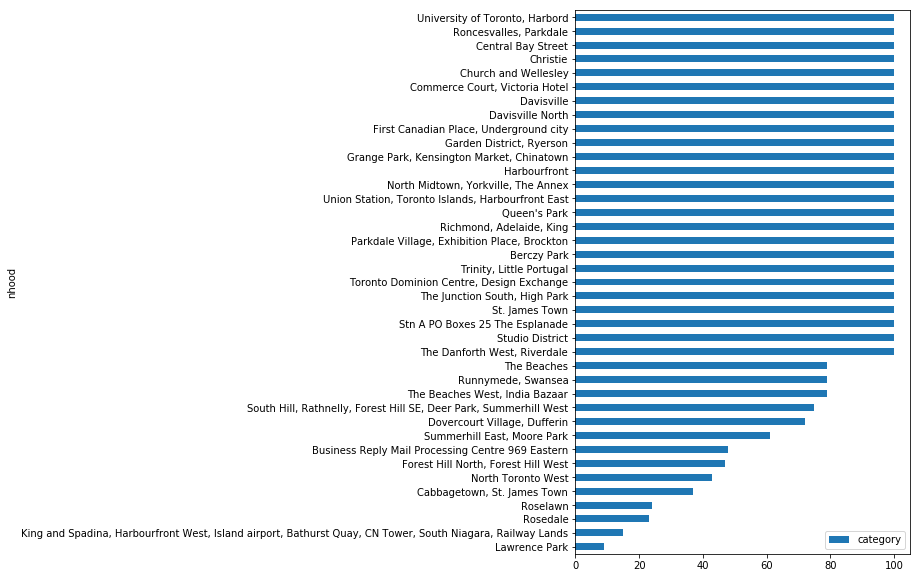

In [106]:
toronto_venues.groupby('nhood').count()[['category']
                ].sort_values('category').plot.barh(figsize=(6,10));

The data include 280 unique categories.

In [115]:
toronto_venues['category'].nunique()

280

### Category sparsity

Retrieve category hierarchy from foursquare API

In [123]:
req_params = {
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
    'v': VERSION,
    }
url = 'https://api.foursquare.com/v2/venues/categories'

# make the GET request
category_tree = requests.get(url, req_params).json()

Define a recursive function to walk the hierarchy

In [414]:
def show_category_tree(tree, level=0, parent=None, categories=[]):
    if not tree:
        return categories
    else:
        for category in tree:
            categories.append({
                'category': category['name'],
                'level': level,
                'parent': parent
            })
            show_category_tree(category['categories'], level=level+1, 
                               parent=category['name'], categories=categories)
        return categories

Put the category hierarchy in a DataFrame. We have 941 total categories (of which 280 are represented in our dataset)

In [415]:
categories = pd.DataFrame(show_category_tree(category_tree['response']['categories']))
categories.shape

(941, 3)

Most of the canoncial categories are at levels 1 and 2

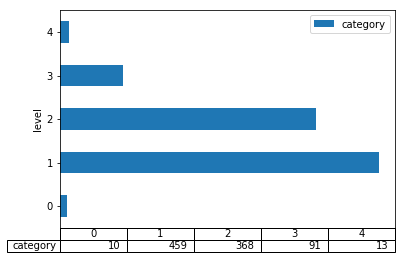

In [426]:
categories.groupby('level').count()[['category']].plot.barh(table=True, xticks=[]);

In [209]:
categories.head()

,category,level,parent
0,Arts & Entertainment,0,None
1,Amphitheater,1,Arts & Entertainment
2,Aquarium,1,Arts & Entertainment
3,Arcade,1,Arts & Entertainment
4,Art Gallery,1,Arts & Entertainment


The distribution of categories in the Toronto venues data is light at level 2, and we see few venues categorized at levels 3 & 4.

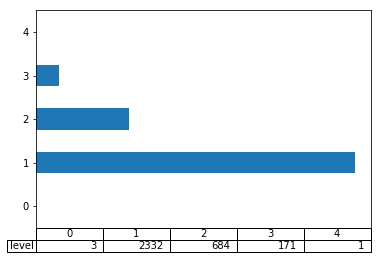

In [424]:
toronto_venues.merge(categories, how='left', left_on='category', right_on='category'
                    )['level'].value_counts(dropna=False).sort_index(
                    ).plot.barh(table=True, xticks=[]);

Let's create a "category group" field to allow us to roll up venue categories into higher levels.

In [429]:
def map_category_group(category, max_depth=0):
    current_depth = categories[categories['category'] == category]['level'].values[0]
    current_group = categories[categories['category'] == category]['category'].values[0]

    while current_depth > max_depth:
        current_depth -= 1
        current_group = categories[categories['category'] == current_group]['parent'].values[0]
    
    return current_group

And let's make level 2 the lowest level of granularity

In [430]:
toronto_venues['category_group'] = toronto_venues['category'].apply(
    lambda x: map_category_group(x, 2))

In [434]:
toronto_venues[toronto_venues['category'] != toronto_venues['category_group']
              ].sample(10)

,nhood,nhood_lat,nhood_long,venue,v_lat,v_long,category,category_group
2118,"Grange Park, Kensington Market, Chinatown",43.653206,-79.400049,Krudar Muay Thai,43.652815,-79.401368,Martial Arts Dojo,Gym / Fitness Center
487,North Toronto West,43.715383,-79.405678,Toronto Sporting Life 10k,43.711832,-79.399451,Track,Gym / Fitness Center
686,"South Hill, Rathnelly, Forest Hill SE, Deer Pa...",43.686412,-79.400049,Daeco Sushi,43.687838,-79.395652,Sushi Restaurant,Japanese Restaurant
3049,Queen's Park,43.662301,-79.389494,The Yoga Sanctuary,43.661499,-79.383636,Yoga Studio,Gym / Fitness Center
639,"Summerhill East, Moore Park",43.689574,-79.383160,GoodLife Fitness,43.689617,-79.394695,Gym,Gym / Fitness Center
2987,"Runnymede, Swansea",43.651571,-79.484450,Asa Sushi,43.649902,-79.484611,Sushi Restaurant,Japanese Restaurant
1434,"Richmond, Adelaide, King",43.650571,-79.384568,Copacabana Grilled Brazilian,43.648333,-79.388151,Brazilian Restaurant,South American Restaurant
1457,"Richmond, Adelaide, King",43.650571,-79.384568,GoodLife Fitness,43.651242,-79.378068,Gym,Gym / Fitness Center
2007,"University of Toronto, Harbord",43.662696,-79.400049,Miles Nadal Jewish Community Centre,43.666519,-79.403874,Gym,Gym / Fitness Center
301,Studio District,43.659526,-79.340923,Kibo Sushi House,43.662633,-79.332677,Sushi Restaurant,Japanese Restaurant


In [435]:
toronto_venues.groupby('category_group').count()['category'].sort_values(
    ascending=False)

category_group
Coffee Shop                  253
Café                         175
Japanese Restaurant          139
Gym / Fitness Center         103
Italian Restaurant            90
                            ... 
Cajun / Creole Restaurant      1
Pide Place                     1
Pie Shop                       1
Recording Studio               1
Zoo                            1
Name: category, Length: 266, dtype: int64

In [305]:
nhood_categories = pd.crosstab(toronto_venues.nhood, toronto_venues.category_group)

We'll min/max scale the data for clustering.

In [306]:
nhood_categories_scaled = nhood_categories / nhood_categories.max().max()
nhood_categories_scaled

category_group,Accessories Store,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Zoo
nhood,,,,,,,,,,,,,,,,,,,,,
Berczy Park,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,...,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Business Reply Mail Processing Centre 969 Eastern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Central Bay Street,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.133333,0.133333,...,0.133333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Christie,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,...,0.133333,0.000000,0.000000,0.066667,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000
Church and Wellesley,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,...,0.066667,0.000000,0.066667,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000,0.000000
"Commerce Court, Victoria Hotel",0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,...,0.133333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000
Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.066667,0.066667,0.000000,0.066667,0.000000,0.066667,0.000000,0.066667,0.000000,0.000000
Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.066667,0.000000,0.000000,0.066667,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000


## Modeling & evaluation

### Category grouping at level 2

#### k-means

In [325]:
gs_params = {
    'n_clusters': range(2,11)
}

gs = GridSearchCV(KMeans(),
                  gs_params,
                  n_jobs=-1,
                  cv=3)

gs.fit(nhood_categories_scaled)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=8, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1, param_grid={'n_clusters': range(2, 11)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [327]:
gs.best_estimator_.labels_

array([3, 2, 2, 0, 1, 0, 3, 0, 0, 1, 3, 2, 0, 1, 0, 2, 2, 1, 2, 1, 0, 3,
       1, 2, 2, 1, 0, 3, 3, 1, 2, 2, 2, 1, 1, 3, 1, 3, 1], dtype=int32)

In [329]:
gs.best_params_

{'n_clusters': 4}

In [326]:
silhouette_score(nhood_categories_scaled, gs.best_estimator_.labels_)

0.17578604009586238

#### DBSCAN

In [410]:
scores = []
counter = 0
bp = {
    'eps': 1e9,
    'min_samples': 1e9,
    'sil_score': -2
} # best params

for eps in tqdm(np.logspace(-1, 1, 10)):
    for min_samples in range(2, 11):
        for metric in ['euclidean', 'chebyshev', 'manhattan']:
            counter += 1
            dbscan = DBSCAN(eps, min_samples, metric)
            dbscan.fit(nhood_categories_scaled)
            try:
                sil_score = silhouette_score(nhood_categories_scaled, dbscan.labels_)
            except ValueError:
                sil_score = -1.01
            
            r = dbscan.get_params() # results
            r['sil_score'] = sil_score
            r['iteration'] = counter
            r['labels'] = dbscan.labels_
            scores.append(r)
            
            if r['sil_score'] > bp['sil_score'] and len(set(r['labels'])) > 2:
                bp = r.copy()
            elif np.isclose(r['sil_score'], bp['sil_score']):
                if r['eps'] < bp['eps'] or r['min_samples'] < bp['min_samples']:
                    bp = r.copy()

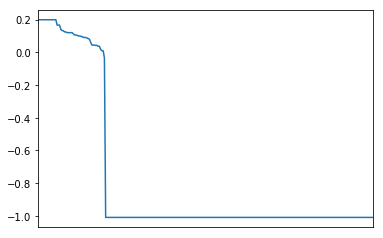

In [397]:
df_dbscan = pd.DataFrame(scores)
df_dbscan['sil_score'].sort_values(ascending=False).reset_index(drop=True).plot(xticks=[]);

In [411]:
bp

{'algorithm': 'auto',
 'eps': 3.593813663804626,
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'min_samples': 2,
 'n_jobs': None,
 'p': None,
 'sil_score': 0.13993877863841364,
 'iteration': 192,
 'labels': array([ 0,  1,  1, -1, -1,  2,  0, -1, -1, -1,  0,  1, -1, -1, -1,  1,  1,
        -1,  1, -1,  2,  0, -1,  1,  1, -1,  1,  0,  0, -1,  1, -1,  1, -1,
        -1,  0, -1, -1, -1])}

### Category grouping at level 3

Since our silhouette scores were poor with our category grouping at level 2, let's try level 3

In [436]:
toronto_venues['category_group'] = toronto_venues['category'].apply(
    lambda x: map_category_group(x, 3))

In [437]:
nhood_categories = pd.crosstab(toronto_venues.nhood, toronto_venues.category_group)
nhood_categories_scaled = nhood_categories / nhood_categories.max().max()

#### k-means

In [438]:
gs_params = {
    'n_clusters': range(2,11)
}

gs = GridSearchCV(KMeans(),
                  gs_params,
                  n_jobs=-1,
                  cv=3)

gs.fit(nhood_categories_scaled)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=8, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1, param_grid={'n_clusters': range(2, 11)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [439]:
gs.best_estimator_.labels_

array([1, 3, 3, 0, 3, 0, 1, 4, 4, 3, 1, 3, 0, 2, 4, 3, 3, 2, 3, 2, 0, 1,
       3, 3, 3, 4, 3, 1, 1, 2, 3, 3, 3, 4, 2, 1, 2, 1, 2], dtype=int32)

In [440]:
gs.best_params_

{'n_clusters': 5}

In [441]:
silhouette_score(nhood_categories_scaled, gs.best_estimator_.labels_)

0.1603972625695662

#### DBSCAN

In [442]:
scores = []
counter = 0
bp = {
    'eps': 1e9,
    'min_samples': 1e9,
    'sil_score': -2
} # best params

for eps in tqdm(np.logspace(-1, 1, 10)):
    for min_samples in range(2, 11):
        for metric in ['euclidean', 'chebyshev', 'manhattan']:
            counter += 1
            dbscan = DBSCAN(eps, min_samples, metric)
            dbscan.fit(nhood_categories_scaled)
            try:
                sil_score = silhouette_score(nhood_categories_scaled, dbscan.labels_)
            except ValueError:
                sil_score = -1.01
            
            r = dbscan.get_params() # results
            r['sil_score'] = sil_score
            r['iteration'] = counter
            r['labels'] = dbscan.labels_
            scores.append(r)
            
            if r['sil_score'] > bp['sil_score'] and len(set(r['labels'])) > 2:
                bp = r.copy()
            elif np.isclose(r['sil_score'], bp['sil_score']):
                if r['eps'] < bp['eps'] or r['min_samples'] < bp['min_samples']:
                    bp = r.copy()

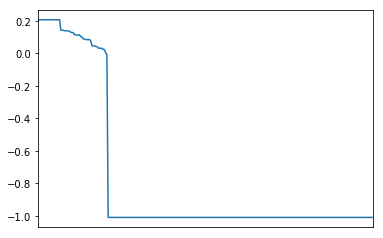

In [443]:
df_dbscan = pd.DataFrame(scores)
df_dbscan['sil_score'].sort_values(ascending=False).reset_index(drop=True).plot(xticks=[]);

In [444]:
bp

{'algorithm': 'auto',
 'eps': 0.774263682681127,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 8,
 'n_jobs': None,
 'p': None,
 'sil_score': 0.1421974423431424,
 'iteration': 127,
 'labels': array([ 1,  0,  0,  1, -1, -1,  1, -1, -1,  0,  1,  0,  1, -1, -1,  0,  0,
        -1,  0, -1, -1,  1, -1,  0,  0, -1,  0,  1,  1, -1,  0, -1,  0, -1,
        -1,  1, -1,  1, -1])}

### Category grouping at level 1

Since our silhouette scores were _still_ poor with our category grouping at level 3, let's try level 1

In [445]:
toronto_venues['category_group'] = toronto_venues['category'].apply(
    lambda x: map_category_group(x, 1))

In [446]:
nhood_categories = pd.crosstab(toronto_venues.nhood, toronto_venues.category_group)
nhood_categories_scaled = nhood_categories / nhood_categories.max().max()

#### k-means

In [447]:
gs_params = {
    'n_clusters': range(2,11)
}

gs = GridSearchCV(KMeans(),
                  gs_params,
                  n_jobs=-1,
                  cv=3)

gs.fit(nhood_categories_scaled)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=8, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1, param_grid={'n_clusters': range(2, 11)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [448]:
gs.best_estimator_.labels_

array([3, 2, 2, 4, 0, 4, 3, 4, 1, 1, 3, 2, 4, 0, 1, 2, 2, 1, 2, 1, 4, 3,
       1, 2, 2, 1, 4, 3, 3, 1, 2, 1, 2, 1, 1, 3, 0, 3, 0], dtype=int32)

In [449]:
gs.best_params_

{'n_clusters': 5}

In [450]:
silhouette_score(nhood_categories_scaled, gs.best_estimator_.labels_)

0.1916653274460645

#### DBSCAN

In [451]:
scores = []
counter = 0
bp = {
    'eps': 1e9,
    'min_samples': 1e9,
    'sil_score': -2
} # best params

for eps in tqdm(np.logspace(-1, 1, 10)):
    for min_samples in range(2, 11):
        for metric in ['euclidean', 'chebyshev', 'manhattan']:
            counter += 1
            dbscan = DBSCAN(eps, min_samples, metric)
            dbscan.fit(nhood_categories_scaled)
            try:
                sil_score = silhouette_score(nhood_categories_scaled, dbscan.labels_)
            except ValueError:
                sil_score = -1.01
            
            r = dbscan.get_params() # results
            r['sil_score'] = sil_score
            r['iteration'] = counter
            r['labels'] = dbscan.labels_
            scores.append(r)
            
            if r['sil_score'] > bp['sil_score'] and len(set(r['labels'])) > 2:
                bp = r.copy()
            elif np.isclose(r['sil_score'], bp['sil_score']):
                if r['eps'] < bp['eps'] or r['min_samples'] < bp['min_samples']:
                    bp = r.copy()

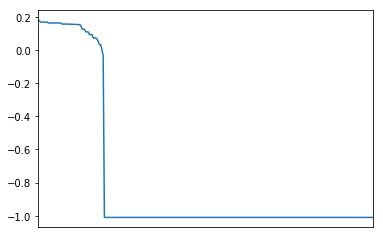

In [452]:
df_dbscan = pd.DataFrame(scores)
df_dbscan['sil_score'].sort_values(ascending=False).reset_index(drop=True).plot(xticks=[]);

In [453]:
bp

{'algorithm': 'auto',
 'eps': 3.593813663804626,
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'min_samples': 2,
 'n_jobs': None,
 'p': None,
 'sil_score': 0.18211960219286935,
 'iteration': 192,
 'labels': array([ 0,  1,  1,  2, -1,  2,  0,  3,  3,  1,  0,  1,  2, -1, -1,  1,  1,
        -1,  1, -1,  2,  0, -1,  1,  1, -1,  1,  0,  0, -1,  1, -1,  1, -1,
        -1,  0, -1,  0, -1])}

### Without category grouping

For good measure, let's check clustering with raw categories

In [454]:
nhood_categories = pd.crosstab(toronto_venues.nhood, toronto_venues.category)
nhood_categories_scaled = nhood_categories / nhood_categories.max().max()

#### k-means

In [455]:
gs_params = {
    'n_clusters': range(2,11)
}

gs = GridSearchCV(KMeans(),
                  gs_params,
                  n_jobs=-1,
                  cv=3)

gs.fit(nhood_categories_scaled)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=8, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1, param_grid={'n_clusters': range(2, 11)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [456]:
gs.best_estimator_.labels_

array([1, 4, 4, 1, 2, 1, 1, 0, 0, 0, 1, 4, 1, 2, 0, 4, 4, 2, 4, 2, 1, 1,
       0, 4, 4, 0, 0, 1, 1, 0, 0, 0, 4, 3, 0, 1, 2, 1, 2], dtype=int32)

In [457]:
gs.best_params_

{'n_clusters': 5}

In [458]:
silhouette_score(nhood_categories_scaled, gs.best_estimator_.labels_)

0.152658489740792

#### DBSCAN

In [459]:
scores = []
counter = 0
bp = {
    'eps': 1e9,
    'min_samples': 1e9,
    'sil_score': -2
} # best params

for eps in tqdm(np.logspace(-1, 1, 10)):
    for min_samples in range(2, 11):
        for metric in ['euclidean', 'chebyshev', 'manhattan']:
            counter += 1
            dbscan = DBSCAN(eps, min_samples, metric)
            dbscan.fit(nhood_categories_scaled)
            try:
                sil_score = silhouette_score(nhood_categories_scaled, dbscan.labels_)
            except ValueError:
                sil_score = -1.01
            
            r = dbscan.get_params() # results
            r['sil_score'] = sil_score
            r['iteration'] = counter
            r['labels'] = dbscan.labels_
            scores.append(r)
            
            if r['sil_score'] > bp['sil_score'] and len(set(r['labels'])) > 2:
                bp = r.copy()
            elif np.isclose(r['sil_score'], bp['sil_score']):
                if r['eps'] < bp['eps'] or r['min_samples'] < bp['min_samples']:
                    bp = r.copy()

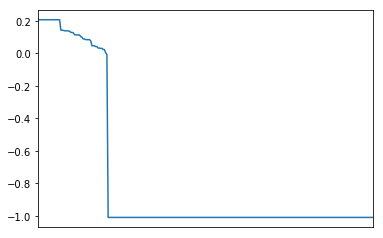

In [460]:
df_dbscan = pd.DataFrame(scores)
df_dbscan['sil_score'].sort_values(ascending=False).reset_index(drop=True).plot(xticks=[]);

In [466]:
score_dist = df_dbscan.groupby('sil_score').count()['iteration']
score_dist/sum(score_dist)

sil_score
-1.010000    0.792593
-0.008642    0.003704
 0.002960    0.003704
 0.022188    0.003704
 0.023042    0.003704
 0.029890    0.007407
 0.031604    0.007407
 0.040857    0.007407
 0.045749    0.011111
 0.076021    0.003704
 0.083479    0.014815
 0.087429    0.007407
 0.098402    0.003704
 0.101897    0.003704
 0.112070    0.011111
 0.113387    0.007407
 0.125559    0.003704
 0.127997    0.007407
 0.135631    0.003704
 0.136606    0.003704
 0.137951    0.011111
 0.140494    0.003704
 0.141635    0.003704
 0.142209    0.003704
 0.205882    0.066667
Name: iteration, dtype: float64

In [461]:
bp

{'algorithm': 'auto',
 'eps': 0.774263682681127,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 8,
 'n_jobs': None,
 'p': None,
 'sil_score': 0.14220879148552454,
 'iteration': 127,
 'labels': array([ 1,  0,  0,  1, -1, -1,  1, -1, -1,  0,  1,  0,  1, -1, -1,  0,  0,
        -1,  0, -1, -1,  1, -1,  0,  0, -1,  0,  1,  1, -1,  0, -1,  0, -1,
        -1,  1, -1,  1, -1])}

----